In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
class NeuralNetwork:
  def ReLU(self, input):
    return np.maximum(0, input)

  def SoftMax(self, input):

    # print("Any NaNs in input?", np.isnan(input).any())

    exp_values = np.exp(input - np.max(input, axis=1, keepdims=True))
    exp_sum = np.sum(exp_values, axis=1, keepdims=True)
    return  exp_values / exp_sum

  def compute_f1_score(self, y_true, y_pred, num_classes):
    f1_scores = []
    for c in range(num_classes):
        tp = np.sum((y_pred == c) & (y_true == c))
        fp = np.sum((y_pred == c) & (y_true != c))
        fn = np.sum((y_pred != c) & (y_true == c))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        if precision + recall == 0:
            f1 = 0.0
        else:
            f1 = 2 * precision * recall / (precision + recall)

        f1_scores.append(f1)

    return np.mean(f1_scores)  # macro-averaged F1

  def compute_precision_recall_auc(self, y_true, y_scores):
    desc_order = np.argsort(-y_scores)
    y_true = y_true[desc_order]
    y_scores = y_scores[desc_order]

    precisions = []
    recalls = []

    tp = 0
    fp = 0
    fn = np.sum(y_true == 1)  # all positives to start with

    for i in range(len(y_scores)):
        if y_true[i] == 1:
            tp += 1
            fn -= 1
        else:
            fp += 1

        precision = tp / (tp + fp) if (tp + fp) > 0 else 1.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        precisions.append(precision)
        recalls.append(recall)

    # Compute area under curve using trapezoidal rule
    precisions = np.array(precisions)
    recalls = np.array(recalls)

    # Sort by recall to compute AUC
    recall_sorted_idx = np.argsort(recalls)
    recalls = recalls[recall_sorted_idx]
    precisions = precisions[recall_sorted_idx]

    auc = np.sum((recalls[1:] - recalls[:-1]) * (precisions[1:] + precisions[:-1]) / 2)

    return auc



  def Loss(self, y_pred, y_true):
    samples = len(y_pred)
    y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

    if len(y_true.shape) == 1:
      correct_confidences = y_pred_clipped[range(samples), y_true]
    elif len(y_true.shape) == 2:
      correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

    # print("y_pred shape:", y_pred_clipped.shape)  # Should be (samples, num_classes)
    # print("Unique y_true labels:", np.unique(y_true))
    # print("Max label in y_true:", np.max(y_true))
    # print("Number of classes in y_pred:", y_pred.shape[1])

    # print("Min y_pred_clipped: ", np.min(y_pred_clipped))
    # print("Min correct_confidences: ", np.min(correct_confidences))

    # print("y_true shape: ", y_true.shape)

    # print(y_pred_clipped)
    # print(y_true)
    # print(correct_confidences)


    assert np.all(y_true >= 0)
    assert np.all(y_true < y_pred.shape[1])


    loss = -np.log(correct_confidences)
    return np.mean(loss)

  def Backward_Loss_Softmax(self, y_pred, y_true):
    samples = len(y_pred)

    if len(y_true.shape) == 2:
      y_true = np.argmax(y_true, axis=1)

    dvalues = y_pred.copy()
    dvalues[range(samples), y_true] -= 1

    return dvalues / samples

  def __init__(self, layers: list):
    self.weights = [] #3D Matrix with a 2-D matrix per layer
    self.biases = []  #2D Matrix with a Vector per layer
    self.layers = layers

    for i in range(len(layers) - 1):
      limit = np.sqrt(6 / (layers[i] + layers[i + 1]))
      self.weights.append(np.random.uniform(-limit, limit, size=(layers[i], layers[i + 1])))
      self.biases.append(np.zeros((1, layers[i + 1])))

  def forward(self, X):
    self.activations = [X]
    self.Z = []

    for i in range(len(self.layers) - 2):
      z = np.dot(self.activations[i], self.weights[i]) + self.biases[i]
      self.activations.append(self.ReLU(z))
      self.Z.append(z)

    z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
    self.activations.append(self.SoftMax(z))
    self.Z.append(z)

    return self.activations[-1]

  def backward(self, X, y):
    dw = [None] * len(self.weights)
    db = [None] * len(self.biases)

    dZ = self.Backward_Loss_Softmax(self.activations[-1], y)

    for i in reversed(range(len(self.weights))):
      dw[i] = self.activations[i].T @ dZ
      db[i] = np.sum(dZ, axis=0, keepdims=True)

      if i != 0:
        dZ = (dZ @ self.weights[i].T) * (self.Z[i - 1] > 0)

    return dw, db

  def train(self, X_train, y_train, alpha=0.001, epochs=30, batch_size=32):

      self.costs = []
      self.iters = []
      self.accuracies = []

      num_samples = len(X_train)
      num_batches = int(np.ceil(num_samples / batch_size))

      for epoch in range(epochs):
          permutation = np.random.permutation(num_samples)
          X_train_shuffled = X_train[permutation]
          y_train_shuffled = y_train[permutation]

          epoch_costs = []

          for i in range(num_batches):
              start = i * batch_size
              end = start + batch_size
              X_batch = X_train_shuffled[start:end]
              y_batch = y_train_shuffled[start:end]

              self.forward(X_batch)
              dw, db = self.backward(X_batch, y_batch)
              batch_cost = self.Loss(self.activations[-1], y_batch) # average loss per batch
              epoch_costs.append(batch_cost)

              for j in range(len(self.weights)):
                  self.weights[j] -= alpha * dw[j]
                  self.biases[j] -= alpha * db[j]

          avg_cost = np.mean(epoch_costs)
          self.costs.append(avg_cost)
          self.iters.append(epoch)

          y_pred = self.forward(X_train)
          predicted_classes = np.argmax(y_pred, axis=1)

          if len(y_train.shape) == 2:
              y_true = np.argmax(y_train, axis=1)
          else:
              y_true = y_train

          accuracy = np.mean(predicted_classes == y_true)
          self.accuracies.append(accuracy)

          f1 = self.compute_f1_score(y_true, predicted_classes, num_classes=self.layers[-1])

          print(f"Epoch {epoch+1}/{epochs} — Loss: {avg_cost:.4f} — Test Accuracy: {accuracy:.4f} — F1 Score: {f1:.4f}")

      return


In [3]:
df = pd.read_csv('/content/train.csv')
df = df.dropna()

df = df[df['Age'] >= 0].reset_index(drop=True)

df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'], errors='coerce')
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'], errors='coerce')

df['waiting_days'] = ((df['AppointmentDay'] - df['ScheduledDay']).dt.days) + 1
df['appointment_weekday'] = df['AppointmentDay'].dt.weekday

df['No-show'] = df['No-show'].map({'No': 0, 'Yes': 1})
df['SMS_received'] = df['SMS_received'].astype(int)
df['Scholarship'] = df['Scholarship'].astype(int)

df = pd.get_dummies(df, columns=['Gender'], drop_first=True)
df['Gender_M'] = df['Gender_M'].astype(int)

df['Neighbourhood_encoded'], uniques = pd.factorize(df['Neighbourhood'])

df = df[df['Handcap'] <= 1]

df['num_prev_appts'] = df.groupby('PatientId').cumcount() + 1
df['missed_before'] = (
    df.groupby('PatientId')['No-show']
    .transform(lambda x: x.shift().cumsum())
    .fillna(0)
)

df['missed_before'] = df['missed_before'].astype(int)

df['prev_no_show_rate'] = df['missed_before'] / df['num_prev_appts']


<ipython-input-3-e0a6fbceff7c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_prev_appts'] = df.groupby('PatientId').cumcount() + 1


In [4]:
df['age_scaled'] = (df['Age'] - df['Age'].mean()) / df['Age'].std()
df['waiting_days'] = (df['waiting_days'] - df['waiting_days'].mean()) / df['waiting_days'].std()
df['Neighbourhood_encoded'] = (df['Neighbourhood_encoded'] - df['Neighbourhood_encoded'].mean()) / df['Neighbourhood_encoded'].std()
df['num_prev_appts'] = (df['num_prev_appts'] - df['num_prev_appts'].mean()) / df['num_prev_appts'].std()
df['appointment_weekday'] = (df['appointment_weekday'] - df['appointment_weekday'].mean()) / df['appointment_weekday'].std()

In [5]:
features = ['age_scaled', 'Scholarship', 'Hipertension', 'Diabetes',
            'Alcoholism', 'Handcap', 'SMS_received', 'waiting_days',
            'appointment_weekday', 'Gender_M', 'Neighbourhood_encoded',
            'prev_no_show_rate', 'num_prev_appts']
target = ['No-show']

In [6]:
print(df.head())

      PatientId  AppointmentID              ScheduledDay  \
0  2.987250e+13        5642903 2016-04-29 18:38:08+00:00   
1  5.589978e+14        5642503 2016-04-29 16:08:27+00:00   
2  4.262962e+12        5642549 2016-04-29 16:19:04+00:00   
3  8.679512e+11        5642828 2016-04-29 17:29:31+00:00   
4  8.841186e+12        5642494 2016-04-29 16:07:23+00:00   

             AppointmentDay  Age      Neighbourhood  Scholarship  \
0 2016-04-29 00:00:00+00:00   62    JARDIM DA PENHA            0   
1 2016-04-29 00:00:00+00:00   56    JARDIM DA PENHA            0   
2 2016-04-29 00:00:00+00:00   62      MATA DA PRAIA            0   
3 2016-04-29 00:00:00+00:00    8  PONTAL DE CAMBURI            0   
4 2016-04-29 00:00:00+00:00   56    JARDIM DA PENHA            0   

   Hipertension  Diabetes  Alcoholism  ...  SMS_received  No-show  \
0             1         0           0  ...             0        0   
1             0         0           0  ...             0        0   
2             0        

waiting_days             0.186062
SMS_received             0.126678
prev_no_show_rate        0.113428
age_scaled              -0.060794
Hipertension            -0.036176
Scholarship              0.029391
num_prev_appts          -0.023118
Neighbourhood_encoded    0.019879
Diabetes                -0.015169
Handcap                 -0.007762
Gender_M                -0.003966
appointment_weekday      0.001437
Alcoholism              -0.000245
Name: No-show, dtype: float64


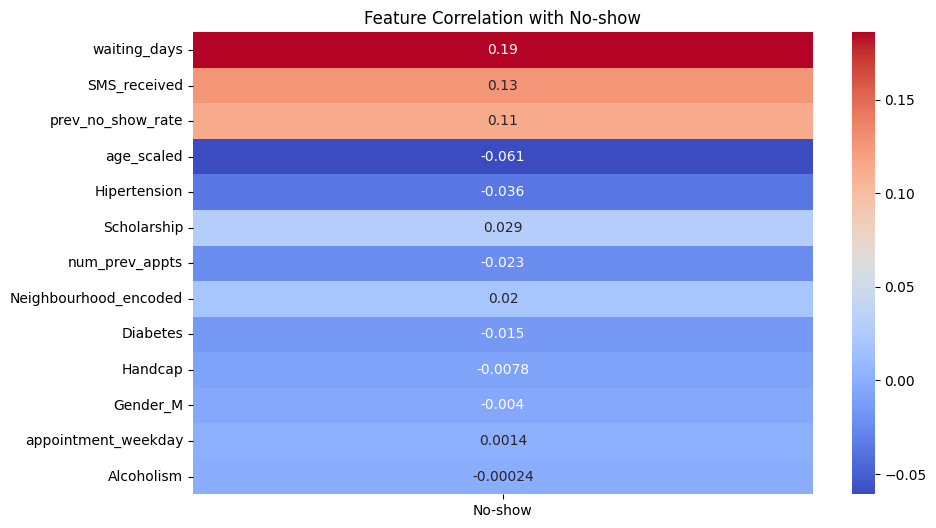

In [7]:
correlations = df[features + target].corr()['No-show'].drop('No-show')

correlations = correlations.sort_values(key=abs, ascending=False)
print(correlations)

plt.figure(figsize=(10, 6))
sns.heatmap(correlations.to_frame(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation with No-show')
plt.show()

In [8]:
X = df[features]
y = df['No-show']

X = X.to_numpy()
y = y.to_numpy()

print(X.shape)

(110327, 13)


In [9]:
data = list(zip(X, y))
random.shuffle(data)

x_shuffled, y_shuffled = zip(*data)
x_shuffled = list(x_shuffled)
y_shuffled = list(y_shuffled)

split_index = int(0.8 * len(x_shuffled))
x_train = np.array(x_shuffled[:split_index])
y_train = np.array(y_shuffled[:split_index])
x_test = np.array(x_shuffled[split_index:])
y_test = np.array(y_shuffled[split_index:])

In [10]:
noodle = NeuralNetwork([13, 128, 64, 32, 2])
noodle.train(x_train, y_train, alpha=0.2, epochs=100, batch_size=64)

Epoch 1/100 — Loss: 0.4607 — Test Accuracy: 0.7988 — F1 Score: 0.4648
Epoch 2/100 — Loss: 0.4486 — Test Accuracy: 0.7871 — F1 Score: 0.5652
Epoch 3/100 — Loss: 0.4448 — Test Accuracy: 0.8018 — F1 Score: 0.5102
Epoch 4/100 — Loss: 0.4421 — Test Accuracy: 0.8021 — F1 Score: 0.5043
Epoch 5/100 — Loss: 0.4410 — Test Accuracy: 0.8014 — F1 Score: 0.4676
Epoch 6/100 — Loss: 0.4394 — Test Accuracy: 0.8013 — F1 Score: 0.5112
Epoch 7/100 — Loss: 0.4389 — Test Accuracy: 0.8024 — F1 Score: 0.4802
Epoch 8/100 — Loss: 0.4379 — Test Accuracy: 0.8024 — F1 Score: 0.4827
Epoch 9/100 — Loss: 0.4376 — Test Accuracy: 0.8025 — F1 Score: 0.4950
Epoch 10/100 — Loss: 0.4370 — Test Accuracy: 0.8030 — F1 Score: 0.4898
Epoch 11/100 — Loss: 0.4362 — Test Accuracy: 0.8027 — F1 Score: 0.4848
Epoch 12/100 — Loss: 0.4360 — Test Accuracy: 0.8031 — F1 Score: 0.4911
Epoch 13/100 — Loss: 0.4360 — Test Accuracy: 0.8028 — F1 Score: 0.4833
Epoch 14/100 — Loss: 0.4356 — Test Accuracy: 0.8031 — F1 Score: 0.4977
Epoch 15/100 — 

In [11]:
y_pred_test = noodle.forward(x_test)
accuracy = np.mean(np.argmax(y_pred_test, axis=1) == y_test)

f1 = noodle.compute_f1_score(y_test, np.argmax(y_pred_test, axis=1), num_classes=2)

y_pred_scores = y_pred_test[:, 1]  # Probability for class '1' (No-show)
pr_auc = noodle.compute_precision_recall_auc(y_test, y_pred_scores)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

Test Accuracy: 0.7722
F1 Score: 0.5781
PR-AUC: 0.3603


In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, labels=["No-show=0", "No-show=1"]):
    cm = np.zeros((2, 2), dtype=int)

    for t, p in zip(y_true, y_pred):
        cm[t][p] += 1

    print("Confusion Matrix:")
    print(cm)

    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap='Blues')
    plt.title("Confusion Matrix")
    fig.colorbar(cax)

    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Annotate cells
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='black')

    plt.show()


Confusion Matrix:
[[16003  1594]
 [ 3433  1036]]


<ipython-input-12-79cce23b9d85>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
<ipython-input-12-79cce23b9d85>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


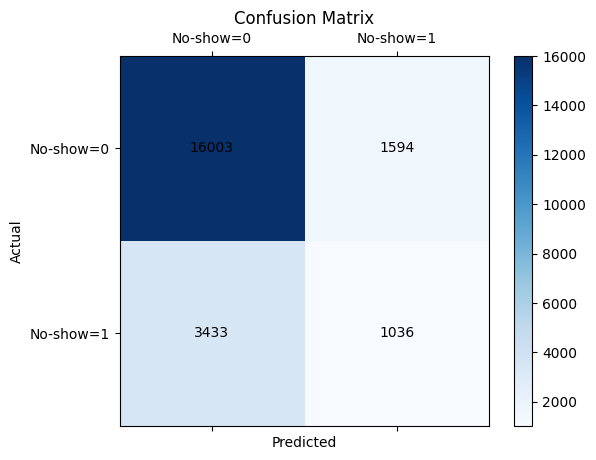

In [13]:
y_pred_classes = np.argmax(y_pred_test, axis=1)
plot_confusion_matrix(y_test, y_pred_classes)